<a href="https://colab.research.google.com/github/reflectormensah/Financial-Engineering-Data-Science/blob/main/Fama_French_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE 652 PORTFOLIO MANAGEMENT

**Group Work Project #1**

*Putting the Fama-French factor models into practice*

**Group 5758** (Yuhua Ren, Revathy Balakrishnan, Reflector Mensah)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from statsmodels.graphics.tsaplots import plot_acf
from IPython.display import display, Math

## Step 1: Defining the 5 Fama-French factors

##Background

The Authors used the data sample of NYSE, NASDAQ and AMEX stocks dated from July, 1963 to December, 2014. They used accounting data from Compustat(CFA Institute Journal Review, 2016).


### Market Risk (MKT-RF)

The market risk factor, denoted as (MKT-RF), represents the excess return of the market portfolio over the risk-free rate. It is the foundation of modern asset pricing models like the Capital Asset Pricing Model (CAPM). MKT-RF captures the systematic risk inherent in investing in the overall market. It reflects the aggregate performance of all stocks in the market, weighted by their market capitalization. Macroeconomic factors such as interest rates, inflation, economic growth, and geopolitical events are all part of market risk. Investors demand compensation for bearing this systematic risk, which is reflected in the expected returns of risky assets relative to risk-free assets.

### Size (SMB)

The size factor, denoted as SMB (Small Minus Big), captures the historical excess returns of small-cap stocks relative to large-cap stocks. It is based on the observation that many small-cap stocks outperform large-cap stocks over the long term, a phenomenon known as the size effect. Small-cap stocks are made up of mostly younger companies with higher growth potential but also higher uncertainty. In contrast, large-cap stocks are more established companies with relatively stable growth prospects. Thus, small-cap stocks are associated with higher levels of risk and reward as compared to large-cap stocks.  SMB measures the performance difference between diversified portfolios of small-cap stocks and diversified portfolios of large-cap stocks. Positive SMB values indicate that small-cap stocks have outperformed large-cap stocks over the specified period, while negative values indicate the opposite.

### Value (HML)

The value factor, denoted as HML (High Minus Low), captures the historical excess returns of value stocks compared to growth stocks. Value stocks are characterized by lower price-to-book (P/B) ratios, while growth stocks have higher P/B ratios. Growth stocks are companies expected to grow their earnings at an above-average rate compared to the overall market or their industry peers. Investors are thus willing to pay a premium for these companies because they anticipate higher future earnings, which lead to the current higher P/B ratio. On the other hand, value stocks are often undervalued by the market relative to their fundamental metrics, such as earnings, dividends, or book value. Investors who identify and invest in undervalued stocks benefit from mean reversion if the market corrects these pricing inefficiencies. HML measures the performance difference between diversified portfolios of high book-to-market (value) stocks and diversified portfolios of low book-to-market (growth) stocks. Positive HML values indicate that value stocks have outperformed growth stocks over the specified period, while negative values indicate the opposite.

### Profitability (RMW)

The profitability factor, denoted as RMW (Robust Minus Weak), captures the historical excess returns of companies with strong profitability compared to those with weak profitability. Profitable companies exhibit robust financial performance, with higher margins, returns on equity, and cash flows compared to less profitable companies. Investors thus perceive these companies as less risky and reward them with higher valuations, leading to higher returns over time. RMW measures the performance difference between diversified portfolios of companies with high and steady operating profitability against diversified portfolios of companies with low operating profitability. Positive RMW values indicate that profitable companies have outperformed less profitable companies over the specified period, while negative values indicate the opposite.

### Investment (CMA)

The investment factor, denoted as CMA (Conservative Minus Aggressive), captures the historical excess returns of companies with conservative investment policies compared to those with aggressive investment policies. The reinvestment ratio is an indicator of the aggressiveness of the investment policies. Other indicators of aggressiveness are the level of capital expenditures (Capex) undertaken by the company, and the amount of debt financing to fund its investment. Conservative companies prioritize stability and sustainability in their investment decisions, maintaining lower levels of Capex and debt relative to their earnings and cash flows. In contrast, aggressive companies pursue growth opportunities more actively, and often at the expense of financial stability. CMA measures the performance difference between diversified portfolios of companies with conservative investment policies and diversified portfolios of companies with aggressive investment policies. Positive CMA values indicate that conservative companies have outperformed aggressive companies over the specified period, while negative values indicate the opposite.

## Step 2: Collect economic data

We will use S&P 500 data ("^GSPC") from 2020-2022 as the main timeseries for analysis. The S&P 500 is a stock market index that measures the performance of 500 of the largest publicly traded companies listed on stock exchanges in the United States. The data will be downloaded using Yahoo finance API.

In [ ]:
sd = "2020-01-01"
ed = "2022-12-31"

# Download the historical data for the S&P 500 index (GSPC)
df_gspc = yf.download("^GSPC", # alternatively, we can use "BTC-USD"
                      start=sd,
                      end=ed,
                      progress=False)

 Visualize the time series data of adjusted close prices.

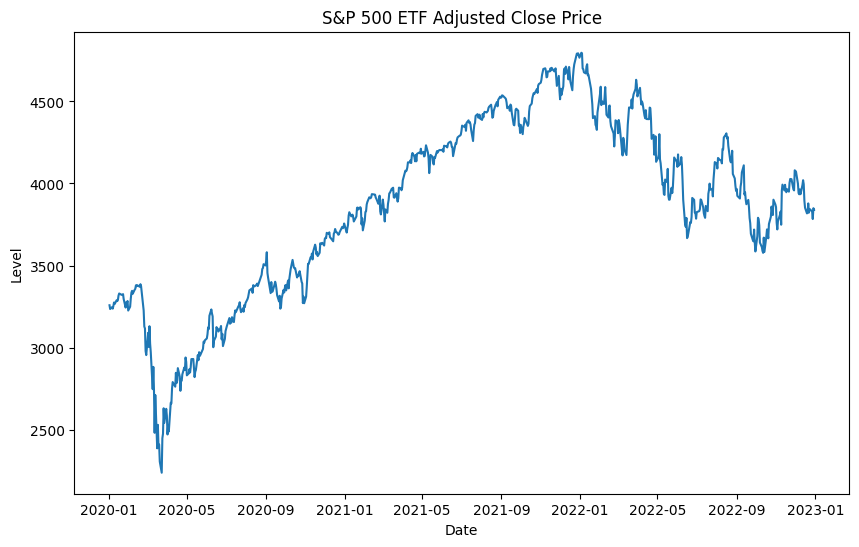

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_gspc['Adj Close'])
plt.title('S&P 500 ETF Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Level')
plt.show()

Compute and analyze summary statistics of daily returns

In [ ]:
# Calculate daily returns
df_gspc['My_Returns'] = df_gspc['Adj Close'].pct_change()
df_gspc.dropna(inplace=True) # Drop the first row, hopefully no missing data
df_gspc = df_gspc[['My_Returns']] # drop all columns except returns
df_gspc.describe()

,My_Returns
count,755.000000
mean,0.000347
std,0.016041
min,-0.119841
25%,-0.006735
50%,0.000881
75%,0.008207
max,0.093828


Plot the autocorrelation function (ACF) of daily returns.

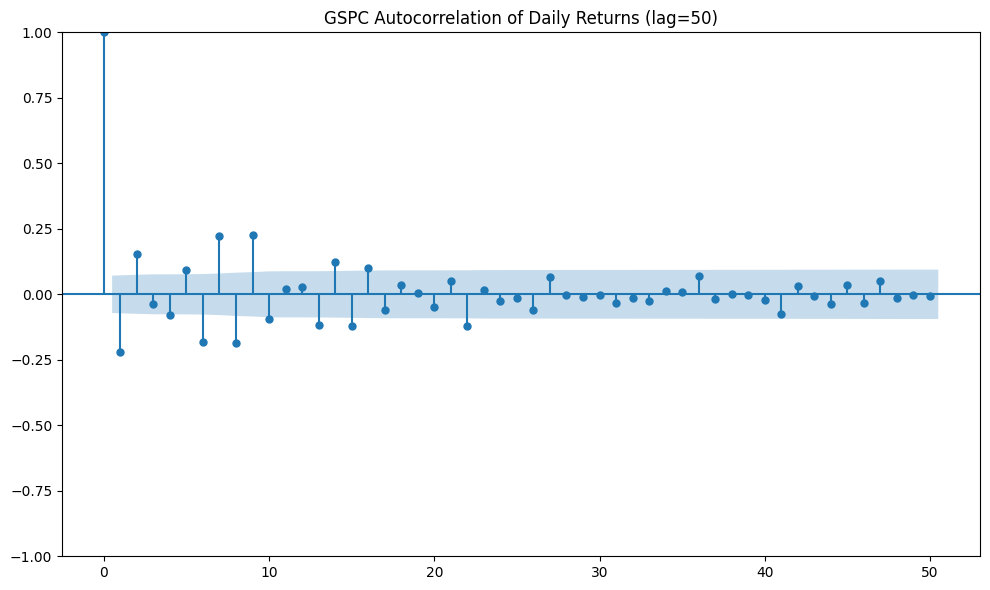

In [ ]:
LAGS=50
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(df_gspc['My_Returns'],
         lags=LAGS,
         title=f'GSPC Autocorrelation of Daily Returns (lag={LAGS})',
         ax=ax)
plt.tight_layout()
plt.show()

Appending the FF5 factors in the dataframe.

In [ ]:
from google.colab import files
# manually upload the file "F-F_Research_Data_5_Factors_2x3_daily.CSV"
uploaded = files.upload()

Saving F-F_Research_Data_5_Factors_2x3_daily.CSV to F-F_Research_Data_5_Factors_2x3_daily.CSV


In [ ]:
# Load Fama-French 5-factor data
ff5_data = pd.read_csv("/content/F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=3)

# Convert 'Date' column to datetime format and set it as index
ff5_data['Date'] = pd.to_datetime(ff5_data['Date'], format="%Y%m%d")
ff5_data.set_index('Date', inplace=True)

# Merge Fama-French factors with our returns dataframe
df_merged = df_gspc.merge(ff5_data, left_index=True, right_index=True)

Check for missing dates in CSV (they show up as null when left-joined). Luckily there are none.

In [ ]:
df_merged[df_merged.isnull().any(axis=1)]

,My_Returns,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,


Here are the first few rows of the dataframe.

In [ ]:
df_merged.head()

,My_Returns,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,
2020-01-03,-0.007060,-0.67,0.30,0.00,-0.14,-0.10,0.006
2020-01-06,0.003533,0.36,-0.20,-0.55,-0.17,-0.26,0.006
2020-01-07,-0.002803,-0.19,-0.03,-0.25,-0.12,-0.25,0.006
2020-01-08,0.004902,0.47,-0.17,-0.64,-0.19,-0.17,0.006
2020-01-09,0.006655,0.65,-0.71,-0.48,-0.14,0.04,0.006


Explore correlations and joint distributions of the factors.

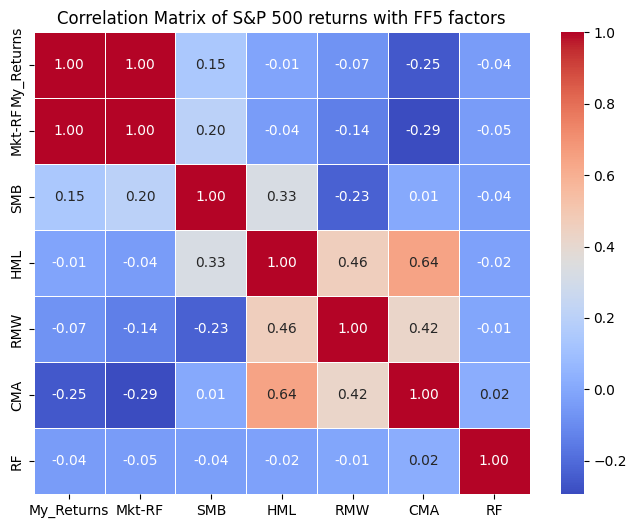

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_merged.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of S&P 500 returns with FF5 factors')
plt.show()

## Step 3: Finding FF3 betas

Correlation Analysis

In [ ]:
# Prepare features and target variable
X = df_merged[['Mkt-RF', 'SMB', 'HML']]  # FF3 factors
y = df_merged['My_Returns']

Linear Regression and Robust Regression

In [ ]:
# Split data into training and testing sets
# Maintain chronological order to prevent leakage
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# print(f"X_train.shape: {X_train.shape}")
# print(f"y_train.shape: {y_train.shape}")
# print(f"X_test.shape: {X_test.shape}")
# print(f"y_test.shape: {y_test.shape}")

# Least Squares (LS) regression
model_ls = LinearRegression()
model_ls.fit(X_train, y_train)
y_pred_ls = model_ls.predict(X_test)
mse_ls = mean_squared_error(y_test, y_pred_ls)
print("Mean Squared Error (Least Squares):\t", mse_ls)

# Robust regression using RANSAC
model_robust = RANSACRegressor()
model_robust.fit(X_train, y_train)
y_pred_robust = model_robust.predict(X_test)
mse_robust = mean_squared_error(y_test, y_pred_robust)
print("Mean Squared Error (Robust):\t\t", mse_robust)

Mean Squared Error (Least Squares):	 7.163599368344912e-07
Mean Squared Error (Robust):		 7.163599368344917e-07


Print coefficients for ordinary least square regression.

In [ ]:
ls_coeff = pd.DataFrame()
ls_coeff["Columns"] = X_train.columns
ls_coeff["Coefficient Estimate (LS)"] = pd.Series(model_ls.coef_)
ls_coeff

,Columns,Coefficient Estimate (LS)
0,Mkt-RF,0.009896
1,SMB,-0.001479
2,HML,0.000723


Print coefficients for robust regression.

In [ ]:
robust_coeff = pd.DataFrame()
robust_coeff["Columns"] = X_train.columns
robust_coeff["Coefficient Estimate (Robust)"] = pd.Series(model_robust.estimator_.coef_)
robust_coeff

,Columns,Coefficient Estimate (Robust)
0,Mkt-RF,0.009896
1,SMB,-0.001479
2,HML,0.000723



Based on the correlation analysis, the strongest correlation is observed between GSPC_Daily_Returns and the Fama-French market factor Mkt-RF, with a correlation coefficient of 0.995, indicating a very strong positive relationship.

Least square coefficients represent the estimated effect on each independent  variable (FF3 factors) with the dependent variable (S&P 500 returns) estimated using the least squares. The estimates are based on reducing the sum of squared residuals.

Robust coefficients represent the estimated effect of each independent variable on the dependent variable using the robust regression. They are less sensitive to the outliers.

In terms of the CAPM, Size (SMB), and value (HML) factors, a positive coefficient for 'Mkt-RF' indicates market risk premium increases, the expected returns on the S&P 500 index also increase. Similarly the coefficient for the risk-free rate ('RF') influences the expected returns on the S&P 500 index, with higher risk-free rates leading to higher expected returns as predicted by the CAPM.
When SMB factor increases,  the S&P 500 returns tend to decrease suggesting that the S&P 500 index is biased towards larger-cap stocks. When the HML factor increases, the S&P 500 returns also increase.



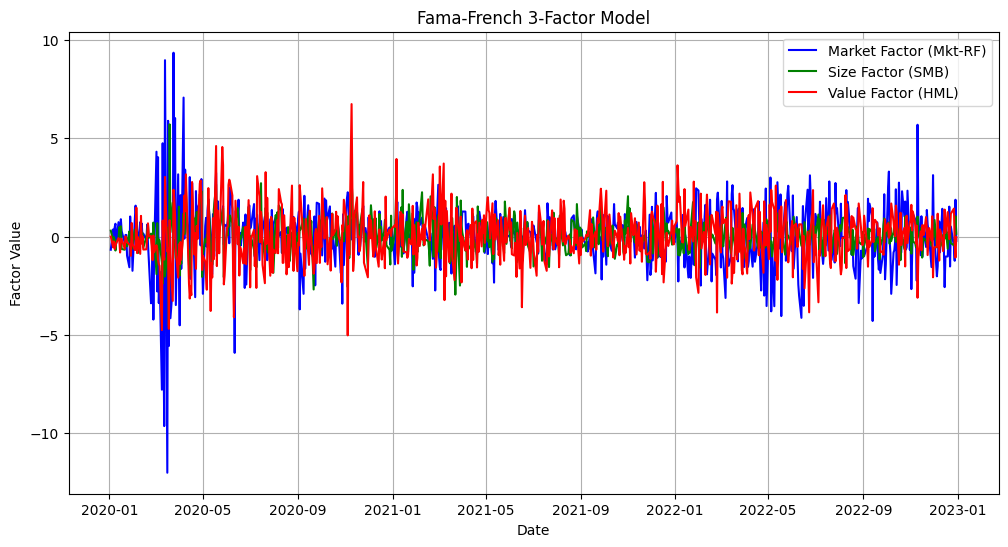

In [ ]:
# Plot Fama-French factors
plt.figure(figsize=(12, 6))

plt.plot(df_merged.index, df_merged['Mkt-RF'], label='Market Factor (Mkt-RF)', color='blue')
plt.plot(df_merged.index, df_merged['SMB'], label='Size Factor (SMB)', color='green')
plt.plot(df_merged.index, df_merged['HML'], label='Value Factor (HML)', color='red')
# plt.plot(df_merged.index, df_merged['RF'], label='Risk-Free Rate (RF)', color='orange')

plt.title('Fama-French 3-Factor Model')
plt.xlabel('Date')
plt.ylabel('Factor Value')
plt.legend()
plt.grid(True)

plt.show()

# Step 4: Finding FF5 betas

Least Squares and Robust regression

In [ ]:
# Prepare features and target variable
X = df_merged[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]  # FF5 factors
y = df_merged['My_Returns']

# Split data into training and testing sets
# Maintain chronological order to prevent leakage
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Least Squares (LS) regression
model_ls = LinearRegression()
model_ls.fit(X_train, y_train)
y_pred_ls = model_ls.predict(X_test)
mse_ls = mean_squared_error(y_test, y_pred_ls)
print("Mean Squared Error (Least Squares):\t", mse_ls)

# Robust regression using RANSAC
model_robust = RANSACRegressor()
model_robust.fit(X_train, y_train)
y_pred_robust = model_robust.predict(X_test)
mse_robust = mean_squared_error(y_test, y_pred_robust)
print("Mean Squared Error (Robust):\t\t", mse_robust)


Mean Squared Error (Least Squares):	 7.994891420415118e-07
Mean Squared Error (Robust):		 7.906631590771537e-07


Coefficients

Print coefficients for ordinary least square regression.

In [ ]:
ls_coeff = pd.DataFrame()
ls_coeff["Columns"] = X_train.columns
ls_coeff["Coefficient Estimate (LS)"] = pd.Series(model_ls.coef_)
ls_coeff

,Columns,Coefficient Estimate (LS)
0,Mkt-RF,0.009945
1,SMB,-0.001131
2,HML,0.000290
3,RMW,0.000899
4,CMA,0.000516


Print coefficients for robust regression

In [ ]:
robust_coeff = pd.DataFrame()
robust_coeff["Columns"] = X_train.columns
robust_coeff["Coefficient Estimate (Robust)"] = pd.Series(model_robust.estimator_.coef_)
robust_coeff

,Columns,Coefficient Estimate (Robust)
0,Mkt-RF,0.009940
1,SMB,-0.001121
2,HML,0.000253
3,RMW,0.000936
4,CMA,0.000521


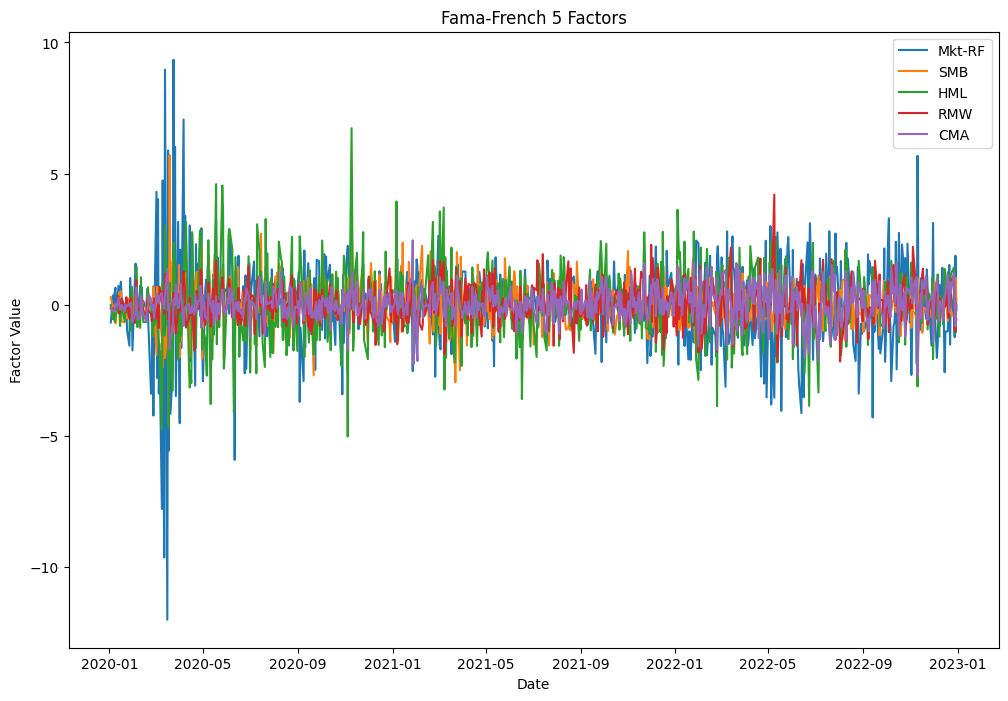

In [ ]:
# Plotting the FF5 factors
plt.figure(figsize=(12, 8))
plt.plot(df_merged['Mkt-RF'], label='Mkt-RF')
plt.plot(df_merged['SMB'], label='SMB')
plt.plot(df_merged['HML'], label='HML')
plt.plot(df_merged['RMW'], label='RMW')
plt.plot(df_merged['CMA'], label='CMA')
# plt.plot(df_merged['RF'], label='RF')
plt.title('Fama-French 5 Factors')
plt.xlabel('Date')
plt.ylabel('Factor Value')
plt.legend()
plt.show()

The least squares and the robust regression methods show very similar mean squared error values indicating that the models perform comparably in terms of prediction accuracy.
The positive coefficient for Market Risk Premium (Mkt-RF) suggests that every unit increase in market risk premium also increases the S&P 500 index daily returns. Similarly, the coefficient estimate for the Risk-Free Rate (RF) suggests that every unit increase in risk-free rate also increases the S&P 500 index daily returns. Similar to this, as the coefficient for High Minus Low (HML) increases, the S&P 500 daily returns are expected to increase slightly.
The negative coefficient for Small Minus Big (SMB) indicates that when the size premium increases, the S&P 500 daily returns are expected to decrease.
The coefficient estimates for Robust minus weak (RMW) and Conservative minus aggressive (CMA) suggests that the profitability and investment factors increase, the S&P 500 daily returns expected to increase.



# Step 5: Covariance and Correlation matrix

Correlation Matrix of Fama-French Factor Returns:

In [ ]:
# Computing the correlation matrix of the factor returns
ff_data = df_merged[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]

correlation_matrix = ff_data.corr()
correlation_matrix

,Mkt-RF,SMB,HML,RMW,CMA,RF
Mkt-RF,1.000000,0.202447,-0.042698,-0.140088,-0.293901,-0.045876
SMB,0.202447,1.000000,0.325905,-0.232665,0.006360,-0.035179
HML,-0.042698,0.325905,1.000000,0.460750,0.644491,-0.022663
RMW,-0.140088,-0.232665,0.460750,1.000000,0.420216,-0.010836
CMA,-0.293901,0.006360,0.644491,0.420216,1.000000,0.023123
RF,-0.045876,-0.035179,-0.022663,-0.010836,0.023123,1.000000


The correlation matrix can be found above, using the 'daily factor data'. It can be seen that it is symmetric.

Covariance Matrix of Factor Returns:

In [ ]:
# Computing the covariance matrix of factor returns
cov_matrix = ff_data.cov()
cov_matrix

,Mkt-RF,SMB,HML,RMW,CMA,RF
Mkt-RF,2.687874,0.287558,-0.094422,-0.168853,-0.302867,-0.000320
SMB,0.287558,0.750622,0.380860,-0.148199,0.003464,-0.000130
HML,-0.094422,0.380860,1.819403,0.456911,0.546421,-0.000130
RMW,-0.168853,-0.148199,0.456911,0.540511,0.194188,-0.000034
CMA,-0.302867,0.003464,0.546421,0.194188,0.395086,0.000062
RF,-0.000320,-0.000130,-0.000130,-0.000034,0.000062,0.000018


Also, the covariance matrix is symmetric as expected.

##Comparing the Correlation Matrix to the Covariance Matrix

Correlation and covariance matrices tend to ascertain how dependent and related two variables are. However, correlation matrix measures the strength (0 to 1) and direction (negatively or positive) of the linear relationship between two variables.

On the other hand, covariance matrix shows the direction of this linear relationship of the two variables.
We can therefore conclude that, correlation matrix is a function of covariance matrix.

We can see from the above correlation and covariance matrices the same direction of the linear relationships. Thus, **the negative and positive relationships in both 6 X 6 matrices are same in their corresponding positions.**

##Contrasting the Correlation Matrix to the Covariance Matrix

Whiles the values in the correlation matrix are **standardized** (-1 to 1), those in the covariance are **not standardized** (from negative infinity to positive infinity). Mathematically,

\begin{align*}
  \rho_{XY} = \frac{\rm{cov}(X,Y)}{\sigma_X \sigma_Y}
\end{align*}

Thus, the correlation matrix indicates the strength between between two variables, within a standardized frame. When the value is 1, then there is a perfect positive linear relationship between the two variables. When the value is -1, then there is a perfect negative relationship between the two variables. When the value is 0, then there is no relationship. However, values lying between -1 and 0, as well as 0 and 1 also show depicts relationships with close values close to 1 or -1 being strong.

For example, in the correlation matrix, the first row is [1.000000  0.202447 -0.042698 -0.140088 -0.293901 -0.045876].
The second value in the matrix is 0.202447, showing a weak positive relationship SMB and Mkt-RF. Also, the third value being -0.042698 shows a weak negative relationship between HML and Mkt-RF. Thus, whiles HML is increasing; Mkt-RF is barely decreasing.

However the covariance matrix shows the extent the two variables change together. So when a covariance value is positive, it shows that both variables increase or decrease together. When a value in the matrix is negative, it indicates whiles one variable is increasing another is decreasing.

For example, in the covariance matrix, the first row is [ 2.687874  0.287558 -0.094422 -0.168853 -0.302867 -0.000320].
The second value shows a positive covariance with a degree of 0.287558.Showing the same movement of both SMB and Mkt-RF.
 Also, the third value shows a negative covariance with a degree of 0.094422. Showing the opposite movement of HML and Mkt-RF.


In conclusion; we can see that correlation speaks within **definite range** for easy interpretation whiles the covariance speaks in **degrees of movement**.

## Step 6: Effects of extra 2 factors (CMA & RMW)

In [ ]:
# Computing correlation coefficients with other factors
# ff5_data = df_gspc[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]

correlation_with_CMA = ff5_data.corr()['CMA'].drop(['CMA', 'RMW'])
correlation_with_RMW = ff5_data.corr()['RMW'].drop(['CMA', 'RMW'])


In [ ]:
# Creating a DataFrame to store the results
ff5_corr_cov = pd.DataFrame({
    'Factor': correlation_with_CMA.index,
    'Correlation with CMA': correlation_with_CMA.values,
    'Correlation with RMW': correlation_with_RMW.values
})

ff5_corr_cov

,Factor,Correlation with CMA,Correlation with RMW
0,Mkt-RF,-0.356554,-0.208578
1,SMB,0.027819,-0.277074
2,HML,0.560127,0.059191
3,RF,0.016051,-0.001504


CMA (Conservative Minus Aggressive):
We could see that the correlation is moderately positive with all the variables except Mkt-RF and correlation with SMB shows a very weak positive. However HML has a strong positive correlation.

RMW (Robust Minus Weak):
From the table above, we realize moderately negative correlation with all variables except HML with a weak positive correlation. However, HML has the relatively strongest correlation with RMW.

## Step 7: Portfolio of 5 stocks

We first review the main results of Markowitz portfolio optimization, following the convention used in the notes. The objective is to minimize
$\vec{w}^T \Sigma \vec{w}$
subjected to
$\vec{w}^T \vec{r} = E[r_p]$ and $\vec{w}^T \vec{\iota} = 1$. The solution is given by
\begin{align*}
  \vec{w}^\star = a + b E[r_p]
\end{align*}

, where
\begin{align*}
  a &= \frac{\Sigma^{-1} (\vec{\iota} \vec{r}^T - \vec{r} \vec{\iota}^T) \Sigma^{-1} \vec{r}}{(\vec{\iota}^T \Sigma^{-1} \vec{\iota}) (\vec{r}^T \Sigma^{-1} \vec{r}) - (\vec{\iota}^T \Sigma^{-1} \vec{r})^2} \\
  b &= - \frac{\Sigma^{-1} (\vec{\iota} \vec{r}^T - \vec{r} \vec{\iota}^T) \Sigma^{-1} \vec{\iota}}{(\vec{\iota}^T \Sigma^{-1} \vec{\iota}) (\vec{r}^T \Sigma^{-1} \vec{r}) - (\vec{\iota}^T \Sigma^{-1} \vec{r})^2}
\end{align*}

By choosing different levels of $E[r_p]$, we will obtain the frontier portfolios.

To put this into practice, we are going to optimize a portfolio of 5 stocks (using data from 2020-2022). We will be using the following 5 US companies from various sectors to form a diversified portfolio.
1. **Amazon.com Inc. (AMZN)**: A multinational e-commerce and cloud computing company known for its dominance in online retail, as well as its Amazon Web Services (AWS) cloud platform.
2. **Bank of America Corporation (BAC)**: One of the largest financial institutions in the United States, providing a wide range of banking and financial services including retail banking, wealth management, investment banking, and asset management.
3. **Exxon Mobil Corporation (XOM)**: One of the world's largest publicly traded oil and gas companies, engaged in exploration, production, refining, and distribution of petroleum products.
4. **Johnson & Johnson (JNJ)**: A diversified healthcare company engaged in pharmaceuticals, medical devices, and consumer health products.
5. **The Walt Disney Company (DIS)**: A multinational entertainment conglomerate known for its film studio, theme parks, media networks, and consumer products. It owns iconic brands like Disney, Pixar, Marvel, Star Wars, and ESPN.

The first step requires us to estimate the mean and variance-covariance. We will use historical data from Yahoo finance to estimate those quantities.

In [ ]:
equity_tickers = ["AMZN", "BAC", "XOM", "JNJ", "DIS"]

equity_data = yf.download(equity_tickers,
                          start=sd,
                          end=ed,
                          progress=False)['Adj Close']

returns_df = equity_data.pct_change()
returns_df.dropna(inplace=True) # Drop the first row

The mean $\vec{r}$ is

In [ ]:
returns_avg = returns_df.mean() # Series type
mu = returns_avg.values.reshape((-1,1)) # 5x1 array
returns_avg

Ticker
AMZN    0.000141
BAC     0.000332
DIS    -0.000417
JNJ     0.000450
XOM     0.001143
dtype: float64

And the variance-covariance matrix $\Sigma$ is

In [ ]:
returns_cov = returns_df.cov() # Dataframe type
sigma = returns_cov.values # 5x5 array
returns_cov

Ticker,AMZN,BAC,DIS,JNJ,XOM
Ticker,,,,,
AMZN,0.000606,0.000203,0.000272,0.000091,0.000120
BAC,0.000203,0.000681,0.000408,0.000169,0.000432
DIS,0.000272,0.000408,0.000582,0.000121,0.000309
JNJ,0.000091,0.000169,0.000121,0.000189,0.000120
XOM,0.000120,0.000432,0.000309,0.000120,0.000650


Now, we are able to calculate the frontier portfolio for a given $E[r_p]$.

In [ ]:
iota = np.ones(len(equity_tickers)).reshape((-1,1)) # 5x1 array
sigma_inv = np.linalg.inv(sigma)
denom = (iota.T @ sigma_inv @ iota) * (mu.T @ sigma_inv @ mu) - (iota.T @ sigma_inv @ mu)**2
numer = sigma_inv @ (iota @ mu.T - mu @ iota.T) @ sigma_inv

a = numer @ mu / denom
b = -numer @ iota / denom

display(Math(r'\vec{a} ='))
print(a)
display(Math(r'\vec{b} ='))
print(b)

<IPython.core.display.Math object>

[[ 0.10261229]
 [-0.09769525]
 [ 0.38416723]
 [ 0.75019549]
 [-0.13927976]]


<IPython.core.display.Math object>

[[  74.92363976]
 [ -35.35869058]
 [-702.58899391]
 [  71.41374751]
 [ 591.61029722]]


Finally, we will plot the variance of the frontier portfolios $\sigma$ for various levels of $E[r_p]$.
\begin{align*}
  \sigma &= \vec{w}^{\star T} \Sigma \vec{w}^{\star} \\
  &= (\vec{a} + E[r_p])^T \Sigma (\vec{a} + E[r_p]) \\
  &= \vec{a}^T \Sigma \vec{a} + 2 E[r_p] \vec{a}^T \Sigma \vec{b} + E[r_p]^2 \vec{b}^T \Sigma \vec{b}
\end{align*}

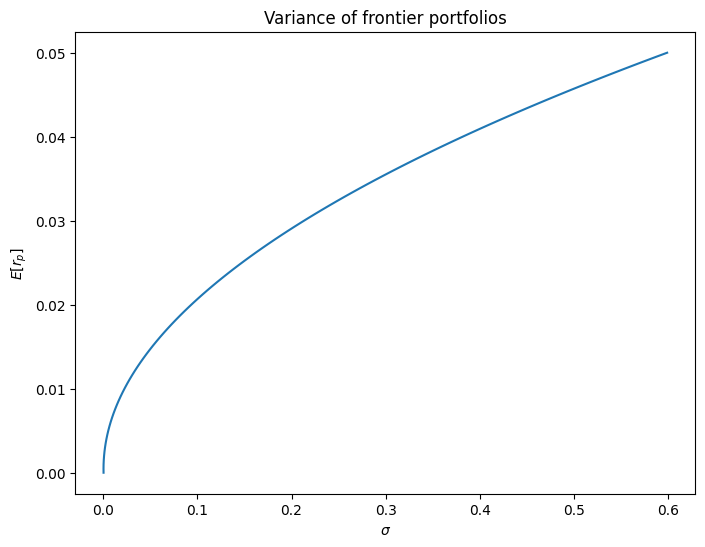

In [ ]:
a0 = (a.T @ sigma @ a)[0,0]
a1 = (2 * a.T @ sigma @ b)[0,0]
a2 = (b.T @ sigma @ b)[0,0]

erp_arr = np.linspace(0,0.05,100)
sigma_arr = a0 + a1 * erp_arr + a2 * erp_arr**2

plt.figure(figsize=(8, 6))
plt.plot(sigma_arr, erp_arr)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$E[r_p]$')
plt.title('Variance of frontier portfolios')
plt.show()

The global minimum occurs at
\begin{align*}
  E[r_p^\star] &= \frac{a_1}{2 a_2} \\
  &= - \frac{\vec{a}^T \Sigma \vec{b}}{\vec{b}^T \Sigma \vec{b}} \\
  &= 0.00044
\end{align*}

Using the weights corresponding to the global minimum of the variance, we run a regression of the portfolio return against the FF3 and FF5 factors.

In [ ]:
wstar = (a + 0.00044 * b)[:,0]
equity_data['Portfolio'] = equity_data[equity_tickers].dot(wstar)
equity_data['Return'] = equity_data['Portfolio'].pct_change()
equity_data.dropna(inplace=True)

# Merge Fama-French factors with our dataframe
equity_data = equity_data.merge(ff5_data, left_index=True, right_index=True)

This is how our dataframe looks like.

In [ ]:
equity_data.head()

,AMZN,BAC,DIS,JNJ,XOM,Portfolio,Return,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,,,,,,,
2020-01-03,93.748497,31.382635,146.024094,128.592834,56.540874,131.581803,-0.011254,-0.67,0.30,0.00,-0.14,-0.10,0.006
2020-01-06,95.143997,31.337677,145.176849,128.432419,56.974972,131.580739,-0.000008,0.36,-0.20,-0.55,-0.17,-0.26,0.006
2020-01-07,95.343002,31.130856,145.226685,129.216736,56.508705,132.215228,0.004822,-0.19,-0.03,-0.25,-0.12,-0.25,0.006
2020-01-08,94.598503,31.445580,144.927658,129.198929,55.656532,131.964600,-0.001896,0.47,-0.17,-0.64,-0.19,-0.17,0.006
2020-01-09,95.052498,31.499542,144.359512,129.582169,56.082619,132.282794,0.002411,0.65,-0.71,-0.48,-0.14,0.04,0.006


We show the correlation with the FF5 factors to better understand our data.

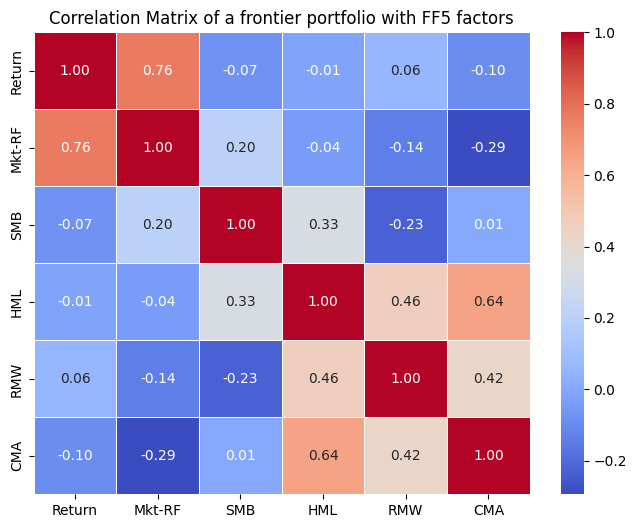

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(equity_data[['Return','Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of a frontier portfolio with FF5 factors')
plt.show()

We observe a strong positive correlation between our portfolio returns and the Mkt-RF factor.

Linear regression with the FF3 factors

In [ ]:
X = equity_data[['Mkt-RF', 'SMB', 'HML']]  # FF3 factors
y = equity_data['Return']

# Split data into training and testing sets
# Maintain chronological order to prevent leakage
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Least Squares (LS) regression
model_ls = LinearRegression()
model_ls.fit(X_train, y_train)
y_pred_ls = model_ls.predict(X_test)
mse_ls = mean_squared_error(y_test, y_pred_ls)
print("Mean Squared Error (Least Squares):\t", mse_ls)

# coefficients
ls_coeff = pd.DataFrame()
ls_coeff["Columns"] = X_train.columns
ls_coeff["Coefficient"] = pd.Series(model_ls.coef_)
ls_coeff

Mean Squared Error (Least Squares):	 4.529045158849768e-05


,Columns,Coefficient
0,Mkt-RF,0.006675
1,SMB,-0.004110
2,HML,0.001174


Linear regression with the FF5 factors

In [ ]:
X = equity_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]  # FF5 factors
y = equity_data['Return']

# Split data into training and testing sets
# Maintain chronological order to prevent leakage
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Least Squares (LS) regression
model_ls = LinearRegression()
model_ls.fit(X_train, y_train)
y_pred_ls = model_ls.predict(X_test)
mse_ls = mean_squared_error(y_test, y_pred_ls)
print("Mean Squared Error (Least Squares):\t", mse_ls)

# coefficients
ls_coeff = pd.DataFrame()
ls_coeff["Columns"] = X_train.columns
ls_coeff["Coefficient"] = pd.Series(model_ls.coef_)
ls_coeff

Mean Squared Error (Least Squares):	 4.6274986267853944e-05


,Columns,Coefficient
0,Mkt-RF,0.006979
1,SMB,-0.003252
2,HML,-0.000387
3,RMW,0.001533
4,CMA,0.003835


## Step 8: Interpretation and discussion

From the FF3 linear regression results, we see that our portfolios have positive correlation with Mkt-Rf and HML, while it is negatively correlated with SMB. The negative correlation means that for an investor who is long in this custom portfolio, she would like the SMB to be negative. This makes sense as all the 5 companies in this portfolio are major companies in the US. This also agrees with our observation in the correlation matrix earlier. For the positive correlation with Mkt-RF, it means that our portfolio is moving with the market. One possible explanation for this concerted movement could be due to investors using index funds or ETFs to track the market. When investors buy or sell these funds, it is as if they are simultaneously buying or selling all stocks in the index.

From the FF5 linear regression results, we see something interesting. The Mkt-RF coefficient did not change much, while the SMB coefficient changed by around 22%. But most surprisingly, the HML coefficient changed from positive to negative. This makes us wonder if we should trust the result from the regression with the FF3 factors. However, we need to bear in mind that when there are too many independent variables, the model may overfit. For the two additional factors RMW and CMA, we see that their coefficients are positive. This indicates that the portfolio is more on the robust and conservative side.

## References

> 1. WorldQuant University (2024). *FACTOR MODELS IN PORTFOLIO THEORY*. Retrieved from https://learn.wqu.edu/my-path/courses/portfolio-management/modules/m-2-elements-of-advanced-classical-portfolio-theory/tasks/lesson-4-factor-models-in-portfolio-theory-lesson-notes. Accessed on 2024-04-22.
> 2. K. French (2024). *CURRENT RESEARCH RETURNS*. Retrieved from https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html. Accessed on 2024-04-22.
> 3. D. Chen (2024). *FAMA FRENCH FIVE FACTORS*. Retrieved from https://www.quantconnect.com/research/15262/fama-french-five-factors/p1. Accessed on 2024-04-23.